# samwich_demo
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov) -- 2017-01-03

This demo was created after updating SAMWICh Box for Python 3 compatibility.

Sample data were provided by [Paula Doubrawa](mailto:paula.doubrawa@nrel.gov)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from samwich.dataloaders import planar_data
from samwich.waketrackers import track

List available wake trackers

In [2]:
track()

Need to specify 'method' as one of:
  ConstantArea (samwich.contour.ConstantAreaTracker)
  ConstantFlux (samwich.contour.ConstantFluxTracker)
  Gaussian2D (samwich.gaussian.Gaussian2DTracker)
  Gaussian (samwich.gaussian.GaussianTracker)


['ConstantArea', 'ConstantFlux', 'Gaussian2D', 'Gaussian']

## Case-specific parameters

In [3]:
D = 27.0  # to define the search range, and the reference area for the contour methods
zhub = 32.1  # hub height [m], for estimating the freestream reference velocity
refInduction = 0.3  # for estimating the momentum theory mass/momentum flux

## Read in test data
Note: General dataloaders exist to handle multiple sampling locations and/or many samples over time.

In [4]:
sample = {}
kinds = ['instantaneous','mean']
varlist = ['x','y','z','u','v','w']
for kind in kinds:
    sample[kind] = planar_data({v: np.loadtxt(f'MWE-data/3D_{kind}_{v}_WFoR.txt') for v in varlist})
sample

{'instantaneous': Vector data array with shape (1,191,139),
 'mean': Vector data array with shape (1,191,139)}

## Calculate freestream
Note: This is an optional step if upstream data are available.

In [5]:
data = {v: np.loadtxt(f'MWE-data/freestream_mean_{v}_WFoR.txt') for v in varlist}
free_z = data['z'][0,:]
free_Uprofile = np.mean(data['u'],axis=0)
jhub = np.argmin(np.abs(data['y'][:,0]-np.mean(data['y'][:,0])))
khub = np.argmin(np.abs(data['z'][0,:]-zhub))
ref_velocity = data['u'][jhub,khub]
free_const = free_Uprofile*0.0 + ref_velocity
print('ref velocity is',ref_velocity)

ref velocity is 6.66985855074


Text(0,0.5,'z (m)')

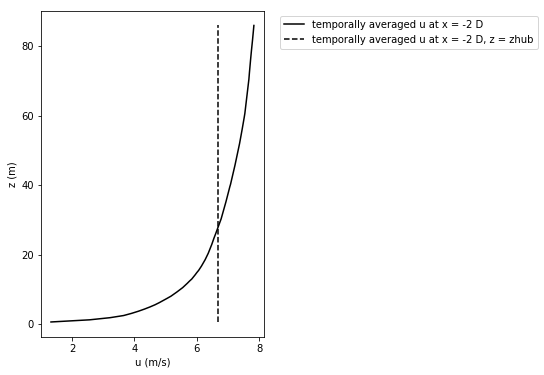

In [6]:
plt.figure(figsize=(4,6))
plt.plot(free_Uprofile,free_z,'-k',label='temporally averaged u at x = -2 D')
plt.plot(free_const,free_z,'--k',label='temporally averaged u at x = -2 D, z = zhub')
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.xlabel('u (m/s)')
plt.ylabel('z (m)')

## Create wake tracking objects

In [7]:
wake = { kind: track(sample[kind].sliceI(),
                     method='ConstantArea',
                     verbose=True) 
         for kind in kinds }

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantArea

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing contourwaketracker

...finished initializing ConstantArea 

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantArea

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketrac

Initializing plot
Initializing plot


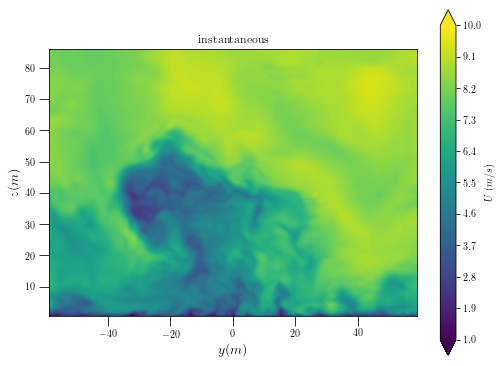

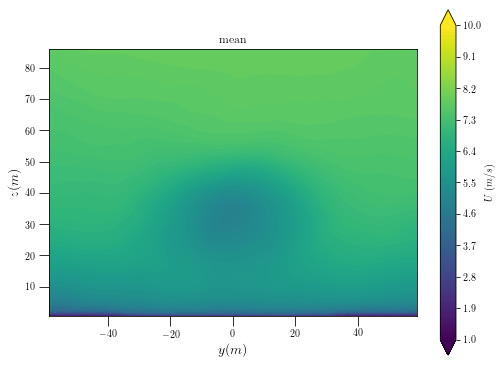

In [8]:
c1,c2 = 1.0, 10.
for iax,kind in enumerate(kinds):
    wake[kind].clear_plot()  # force replot for python notebook
    wake[kind].plot_contour(vmin=c1,vmax=c2)
    plt.title(kind)

## Remove shear
Note: This never works perfectly in practice.

  subtracting out constant profile
Initializing plot
  subtracting out constant profile
Initializing plot


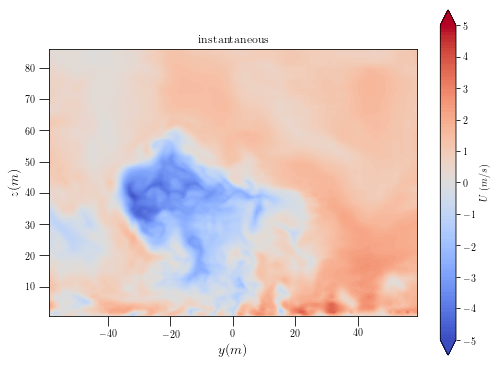

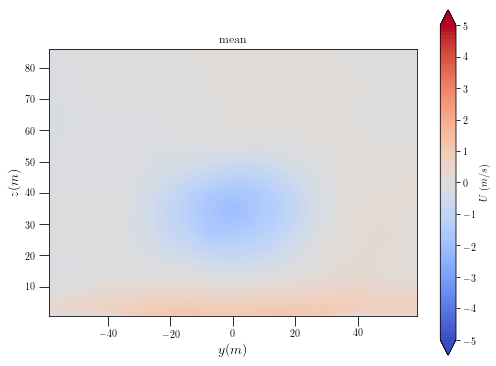

In [9]:
c1,c2 = -5,5
# input profile array should match wake.Nv (v: "vertical")
# otherwise interpolate to wake.z[0,:] locations first...
for kind in kinds:
    #wake[kind].remove_shear(wind_profile=free_const)
    wake[kind].remove_shear(wind_profile=free_Uprofile)
    wake[kind].clear_plot()  # force replot for python notebook
    wake[kind].plot_contour(vmin=c1,vmax=c2,cmap='coolwarm')
    plt.title(kind)

## Find the wake center

In [10]:
refArea = np.pi*D**2
yc,zc = {},{}
for kind in kinds:
    wake[kind].wake_tracked = False  # force recalculation for python notebook
    #yc[kind],zc[kind] = wake[kind].find_centers(refArea, weighted_center=False)  # geometric center
    #yc[kind],zc[kind] = wake[kind].find_centers(refArea, weighted_center=True)  # weighted by velocity deficit
    yc[kind],zc[kind] = wake[kind].find_centers(refArea, weighted_center=lambda u: u**2)  # specified weighting function

Attempting to match area: 2290.221044466959 m^2
Attempting to match area: 2290.221044466959 m^2


Processed frame 0
Processed frame 0


Initializing plot
Initializing plot


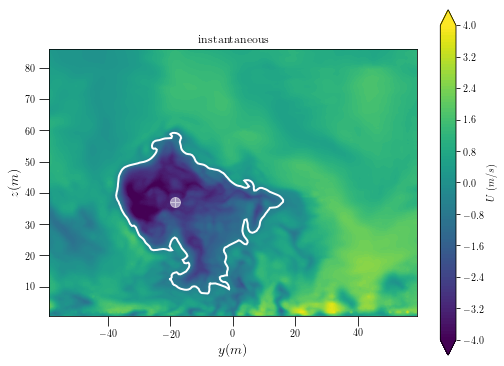

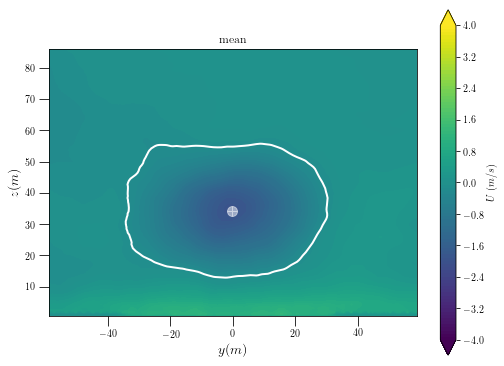

In [11]:
c1,c2 = -4,4
for kind in kinds:
    wake[kind].clear_plot()  # force replot for python notebook
    wake[kind].plot_contour(vmin=c1,vmax=c2,
                            outline=True)  # if the selected tracker detects/approximates the wake edge,
                                           # then let's plot it
    plt.title(kind)

In [12]:
for kind in kinds:
    print(kind,'center at',(yc[kind][0],zc[kind][0]))  # time "0"

instantaneous center at (-18.612534498396538, 37.112271293574601)
mean center at (-0.45225225786952583, 34.125718934793454)
